In [1]:
!pip install torchinfo

In [2]:
! pip install nibabel tensorflow scipy


In [3]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


import albumentations as A
from albumentations import Compose, HorizontalFlip

import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy.ndimage import zoom

from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [4]:
import torch
import torch.nn as nn

class DownsamplingResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(DownsamplingResidualBlock3D, self).__init__()

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Skip connection
        self.skip_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.skip_bn = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        identity = self.skip_bn(self.skip_conv(x))

        out = self.leaky_relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = self.leaky_relu(out)

        return out

class UpsamplingResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super(UpsamplingResidualBlock3D, self).__init__()

        self.conv_transpose1 = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Skip connection
        self.skip_conv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=1, stride=stride, output_padding=1)
        self.skip_bn = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        identity = self.skip_bn(self.skip_conv(x))

        out = self.leaky_relu(self.bn1(self.conv_transpose1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = self.leaky_relu(out)

        return out

class UNet3DWith3DLatent(nn.Module):
    def __init__(self):
        super(UNet3DWith3DLatent, self).__init__()

        # Encoder part
        self.initial_conv = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm3d(32)
        )

        self.encoder = nn.Sequential(
            DownsamplingResidualBlock3D(32, 32),
            DownsamplingResidualBlock3D(32, 64),
            DownsamplingResidualBlock3D(64, 128),
            DownsamplingResidualBlock3D(128, 256)
        )

        # Latent space (remains 3D)
        # No flattening or linear layers, we directly pass the output to the decoder

        # Decoder part
        self.decoder = nn.Sequential(
            UpsamplingResidualBlock3D(256, 256),
            UpsamplingResidualBlock3D(256, 128),
            UpsamplingResidualBlock3D(128, 64),
            UpsamplingResidualBlock3D(64, 32)
        )

        self.final_conv = nn.Conv3d(32, 1, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        # Encoder
        x = self.initial_conv(x)
        x = self.encoder(x)

        latent = x

        # Decoder
        x = self.decoder(latent)

        # Final conv
        x = self.final_conv(x)

        return x


In [5]:
import torch
import torchinfo

model = UNet3DWith3DLatent()

# batch_size=2, channels=1, depth=64, height=64, width=64 (adjust as per your input dimensions)
torchinfo.summary(model, input_size=(2, 1, 16,  128,  128))


Layer (type:depth-idx)                        Output Shape              Param #
UNet3DWith3DLatent                            [2, 1, 16, 128, 128]      --
├─Sequential: 1-1                             [2, 32, 16, 128, 128]     --
│    └─Conv3d: 2-1                            [2, 32, 16, 128, 128]     4,032
│    └─LeakyReLU: 2-2                         [2, 32, 16, 128, 128]     --
│    └─BatchNorm3d: 2-3                       [2, 32, 16, 128, 128]     64
├─Sequential: 1-2                             [2, 256, 1, 8, 8]         --
│    └─DownsamplingResidualBlock3D: 2-4       [2, 32, 8, 64, 64]        --
│    │    └─Conv3d: 3-1                       [2, 32, 8, 64, 64]        1,056
│    │    └─BatchNorm3d: 3-2                  [2, 32, 8, 64, 64]        64
│    │    └─Conv3d: 3-3                       [2, 32, 8, 64, 64]        27,680
│    │    └─BatchNorm3d: 3-4                  [2, 32, 8, 64, 64]        64
│    │    └─LeakyReLU: 3-5                    [2, 32, 8, 64, 64]        --
│    │    

In [7]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
import torch.nn.functional as F

def crop_center(img, crop_size):
    z, y, x = img.shape
    start_z = z // 2 - crop_size[0] // 2
    start_y = y // 2 - crop_size[1] // 2
    start_x = x // 2 - crop_size[2] // 2
    return img[start_z:start_z+crop_size[0], start_y:start_y+crop_size[1], start_x:start_x+crop_size[2]]

class MRIDataset(Dataset):
    def __init__(self, mri_folder_path, target_size=(128, 128, 128)):
        self.mri_folder_path = mri_folder_path
        self.file_paths = [os.path.join(mri_folder_path, f) for f in os.listdir(mri_folder_path) if f.endswith('.nii')]
        self.target_size = target_size

    def __len__(self):
        return len(self.file_paths)
    
    def get_slices(self, mri_volume):
        if mri_volume.shape != (1, 128, 128, 128):
            raise ValueError("Input MRI volume must have shape (1, 128, 128, 128).")

        patches = []
        for i in range(8):
            start = i * 16
            end = start + 16
            patch = mri_volume[0, start:end, :, :]
            patches.append(patch)
        return patches

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        img = nib.load(file_path)
        img_data = img.get_fdata()
        mri_cropped = crop_center(img_data, (160, 160, 160))
        img_tensor = torch.tensor(mri_cropped).unsqueeze(0)
        resized_img = F.interpolate(img_tensor.unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False)
        resized_img = resized_img.squeeze(0)
        mri_resized = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min() + 1e-8)
        mri_slices = self.get_slices(mri_resized)
        volume = [tensor.unsqueeze(0) for tensor in mri_slices]
        return volume, volume
    
# def create_dataloader(mri_folder_path, batch_size=1):
#     dataset = MRIDataset(mri_folder_path)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     return dataloader

# mri_folder_path = '/kaggle/input/brainweb'
# batch_size = 1
# train_loader = create_dataloader(mri_folder_path, batch_size)

# for imgs, targets in train_loader:
#     for img in imgs:
#         print(img.shape)



In [8]:
dataset = MRIDataset('/kaggle/input/brainweb')
print(len(dataset))

9


In [10]:
save_dir = './slices'
os.makedirs(save_dir, exist_ok=True)

# Iterate over the DataLoader and save patches
for batch_idx, (imgs, targets) in enumerate(dataset):
    for patch_idx, img in enumerate(imgs):
        patch = img.squeeze(0).numpy()  # Convert to NumPy array and remove the extra dimension
        save_path = os.path.join(save_dir, f'batch_{batch_idx}_patch_{patch_idx}.npy')
        np.save(save_path, patch)  # Save the patch as a .npy file
        print(f'Saved {save_path}')

Saved ./slices/batch_0_patch_0.npy
Saved ./slices/batch_0_patch_1.npy
Saved ./slices/batch_0_patch_2.npy
Saved ./slices/batch_0_patch_3.npy
Saved ./slices/batch_0_patch_4.npy
Saved ./slices/batch_0_patch_5.npy
Saved ./slices/batch_0_patch_6.npy
Saved ./slices/batch_0_patch_7.npy
Saved ./slices/batch_1_patch_0.npy
Saved ./slices/batch_1_patch_1.npy
Saved ./slices/batch_1_patch_2.npy
Saved ./slices/batch_1_patch_3.npy
Saved ./slices/batch_1_patch_4.npy
Saved ./slices/batch_1_patch_5.npy
Saved ./slices/batch_1_patch_6.npy
Saved ./slices/batch_1_patch_7.npy
Saved ./slices/batch_2_patch_0.npy
Saved ./slices/batch_2_patch_1.npy
Saved ./slices/batch_2_patch_2.npy
Saved ./slices/batch_2_patch_3.npy
Saved ./slices/batch_2_patch_4.npy
Saved ./slices/batch_2_patch_5.npy
Saved ./slices/batch_2_patch_6.npy
Saved ./slices/batch_2_patch_7.npy
Saved ./slices/batch_3_patch_0.npy
Saved ./slices/batch_3_patch_1.npy
Saved ./slices/batch_3_patch_2.npy
Saved ./slices/batch_3_patch_3.npy
Saved ./slices/batch

In [11]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class PatchDataset(Dataset):
    def __init__(self, patch_dir):
        self.patch_dir = patch_dir
        self.file_paths = [os.path.join(patch_dir, f) for f in os.listdir(patch_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        patch_path = self.file_paths[index]
        patch = np.load(patch_path)

        # Add channel dimension (1, 16, 128, 128)
        patch_tensor = torch.tensor(patch).unsqueeze(0).float()
        
        return patch_tensor, patch_tensor

patch_dir = '/kaggle/working/slices'

dataset = PatchDataset(patch_dir)

# Define train, validation, and test split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size 

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Train set size:", len(train_loader))
print("Validation set size:", len(val_loader))
print("Test set size:", len(test_loader))


Train set size: 50
Validation set size: 10
Test set size: 12


In [12]:
def save_checkpoint(state, is_best, checkpoint_dir="checkpoints", filename="checkpoint.pth"):
    os.makedirs(checkpoint_dir, exist_ok=True)  # Create directory if not exists
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    torch.save(state, checkpoint_path)
    if is_best:
        best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save(state, best_model_path)
        print(f"Best model saved to {best_model_path}")


In [8]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [10]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
print(device)

cuda


In [12]:
criterion = torch.nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

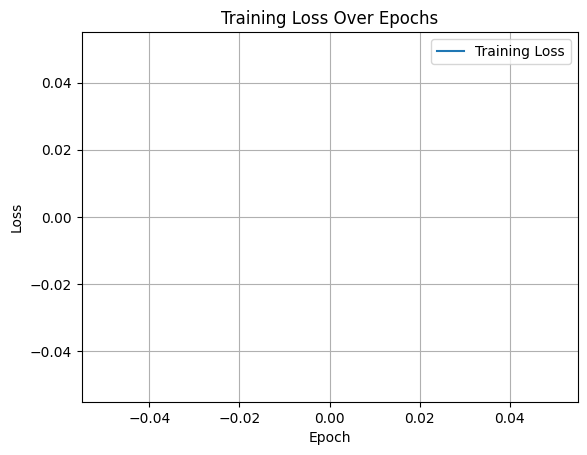

In [18]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_loss_values = []
val_loss_values = []

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    
    # Training loop
    for imgs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)'):
        imgs, targets = imgs.to(device), targets.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Clear gradients
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        train_loss += loss.item()  # Accumulate training loss

    # Average training loss for this epoch
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Turn off gradient calculations for validation
        for imgs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
            imgs, targets = imgs.to(device), targets.to(device)  # Move data to GPU
            outputs = model(imgs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute validation loss
            val_loss += loss.item()  # Accumulate validation loss

    # Average validation loss for this epoch
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)

    # Print the losses for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Check if this is the best model so far and save the checkpoint
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
    
    checkpoint = {
        'epoch': epoch + 1,  # Current epoch
        'model_state_dict': model.state_dict(),  # Model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
        'train_loss': train_loss,  # Last epoch's training loss
        'val_loss': val_loss  # Last epoch's validation loss
    }
    
    save_checkpoint(checkpoint, is_best)
    
# Plotting the loss
clear_output(wait=True)  # Clear the output to update the plot
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


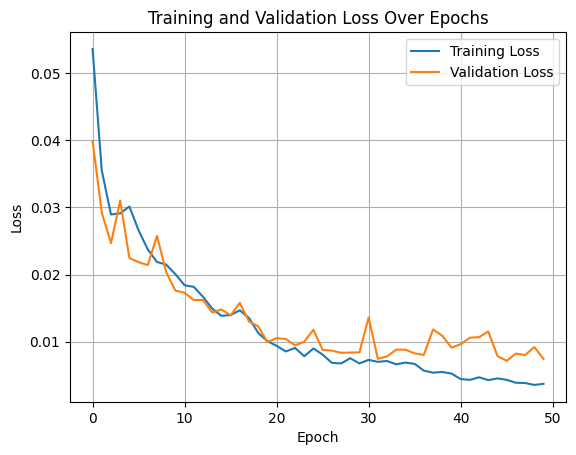

In [19]:
clear_output(wait=True)  # Clear the output to update the plot
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [20]:
# Assuming your model is named 'model'
torch.save(model.state_dict(), 'trained_model.pth')


Testing:   0%|          | 0/12 [00:00<?, ?it/s]

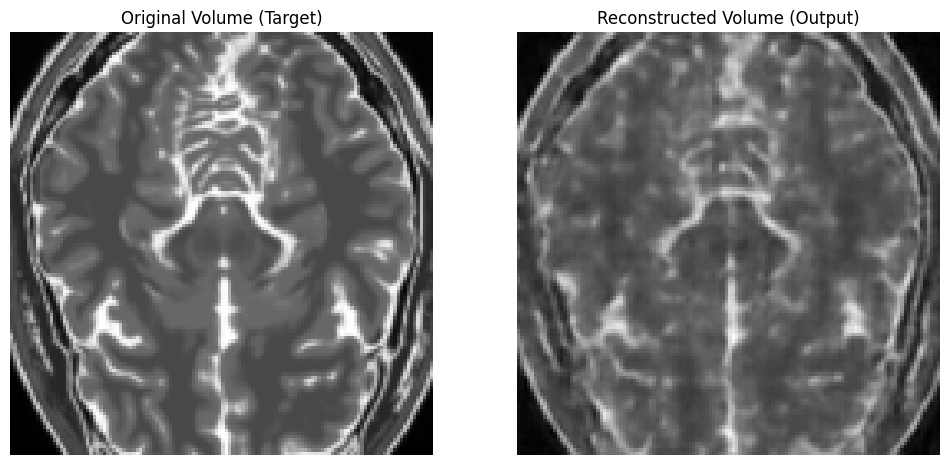

Testing:   8%|▊         | 1/12 [00:00<00:03,  3.10it/s]

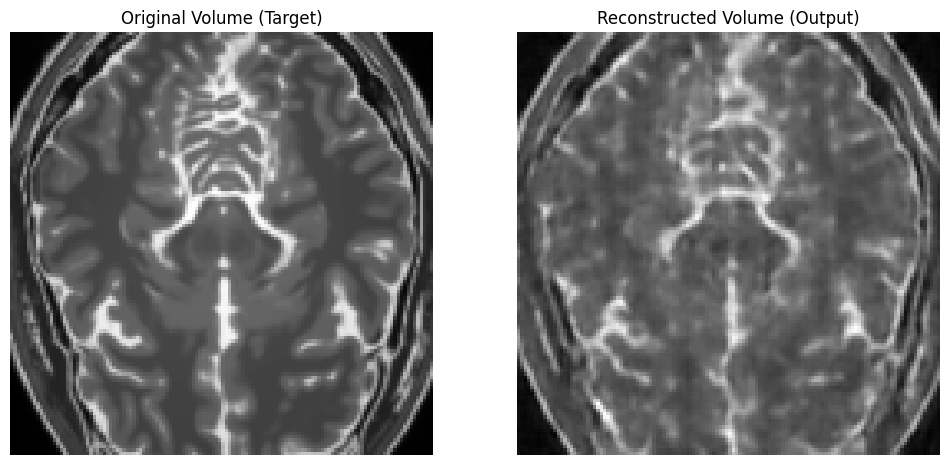

Testing:  17%|█▋        | 2/12 [00:00<00:03,  3.23it/s]

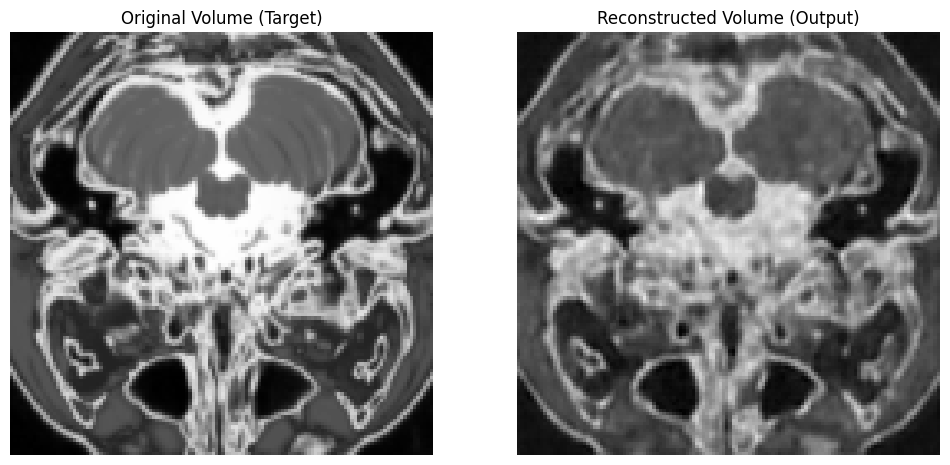

Testing:  25%|██▌       | 3/12 [00:00<00:02,  3.25it/s]

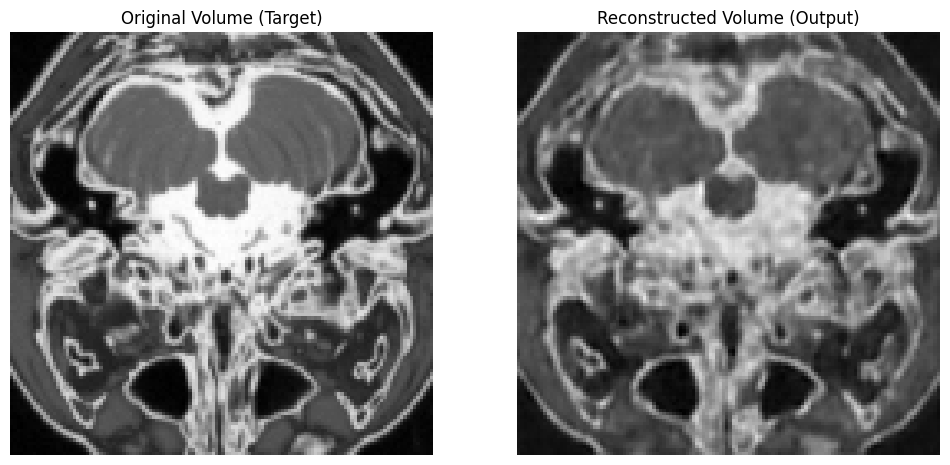

Testing:  33%|███▎      | 4/12 [00:01<00:02,  3.28it/s]

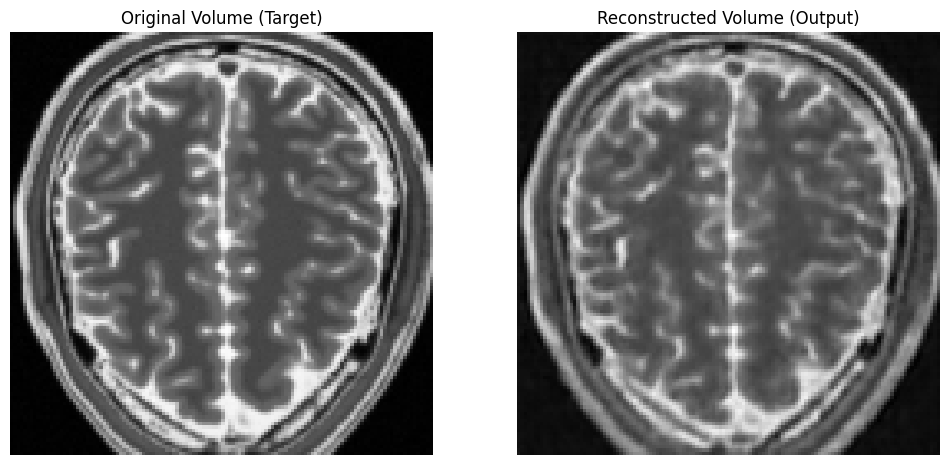

Testing:  42%|████▏     | 5/12 [00:01<00:02,  3.32it/s]

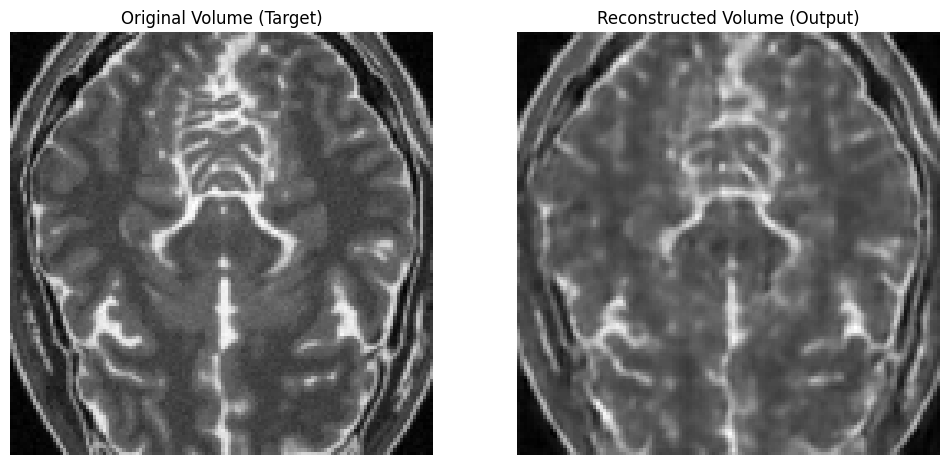

Testing:  50%|█████     | 6/12 [00:01<00:01,  3.34it/s]

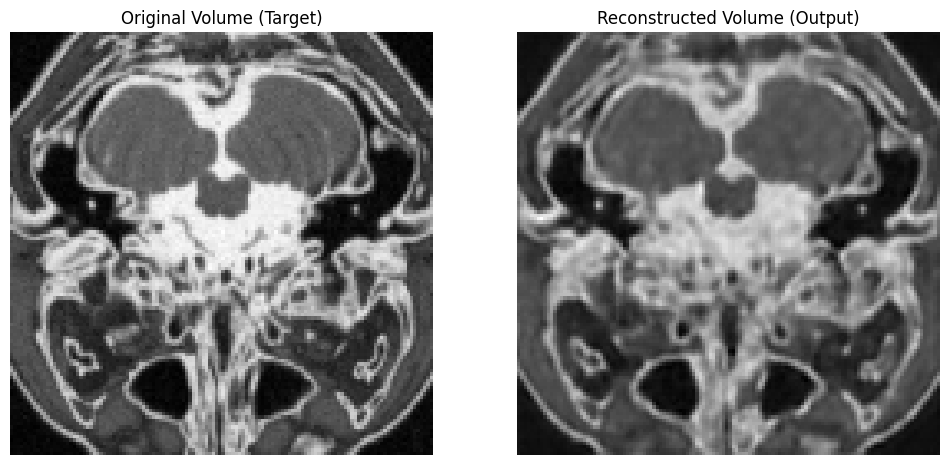

Testing:  58%|█████▊    | 7/12 [00:02<00:01,  3.33it/s]

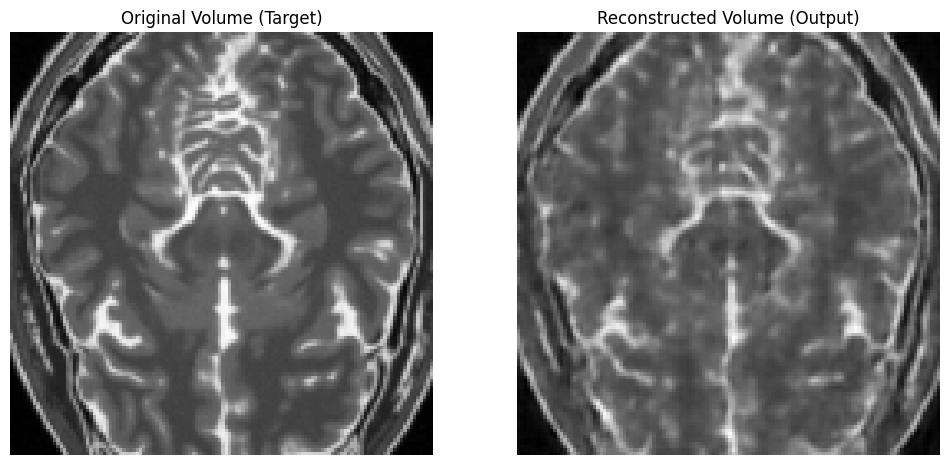

Testing:  67%|██████▋   | 8/12 [00:02<00:01,  3.31it/s]

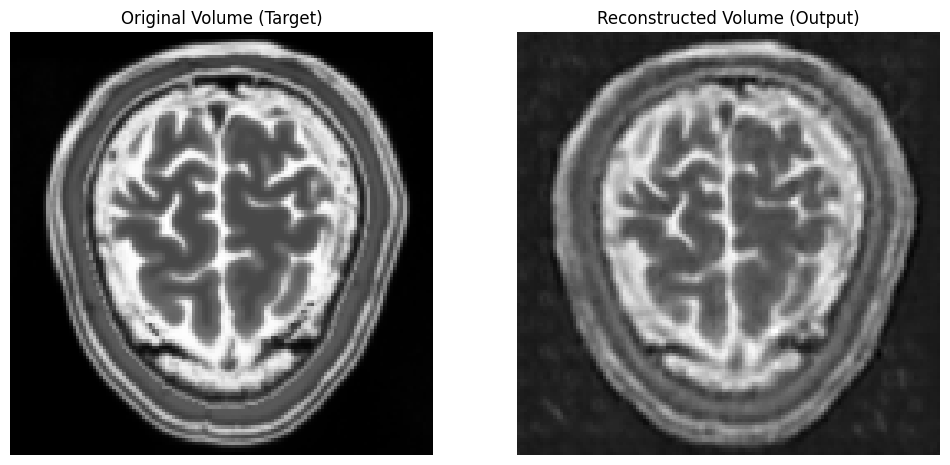

Testing:  75%|███████▌  | 9/12 [00:02<00:00,  3.32it/s]

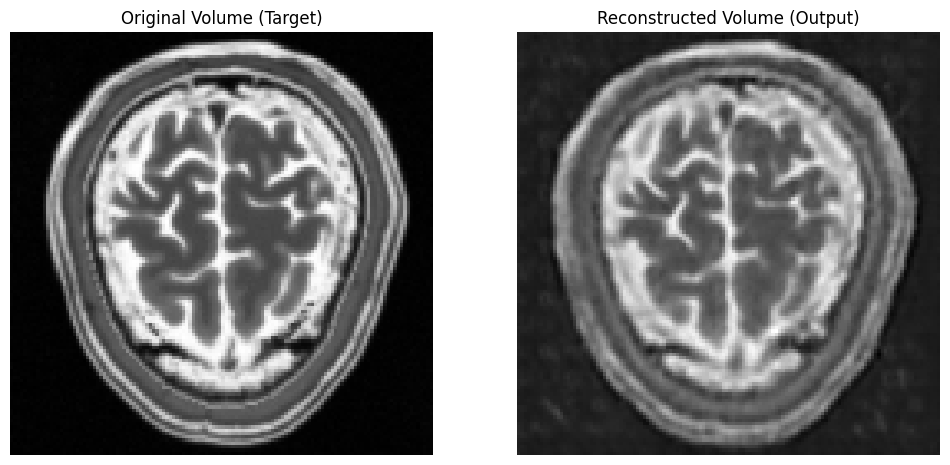

Testing:  83%|████████▎ | 10/12 [00:03<00:00,  3.26it/s]

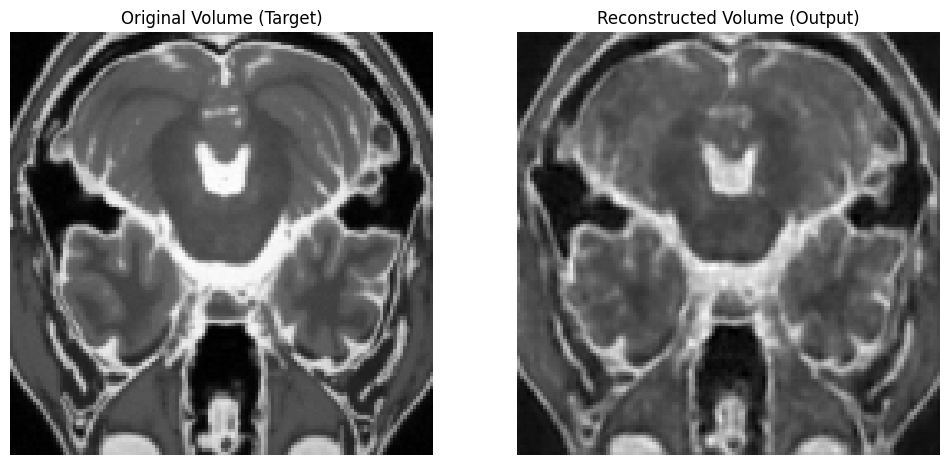

Testing:  92%|█████████▏| 11/12 [00:03<00:00,  3.24it/s]

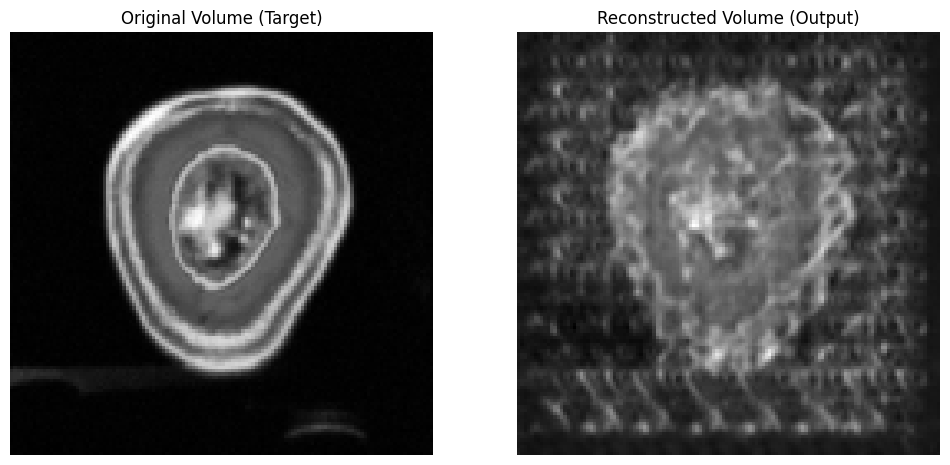

Testing: 100%|██████████| 12/12 [00:03<00:00,  3.27it/s]

Average Test Loss: 0.0061


In [22]:
import matplotlib.pyplot as plt

# Test loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():  # Disable gradient calculations for testing
    for imgs, targets in tqdm(test_loader, desc='Testing'):
        imgs, targets = imgs.to(device), targets.to(device)  # Move data to GPU
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute test loss
        test_loss += loss.item()  # Accumulate test loss

        # Visualize the input and reconstructed volume at depth 8
        depth = 8
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original Volume (Target)
        ax[0].imshow(targets[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[0].set_title('Original Volume (Target)')
        ax[0].axis('off')

        # Reconstructed Volume (Output)
        ax[1].imshow(outputs[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[1].set_title('Reconstructed Volume (Output)')
        ax[1].axis('off')

        plt.show()  # Display the plot

# Average test loss
test_loss /= len(test_loader)
print(f"Average Test Loss: {test_loss:.4f}")


(128, 128, 128)


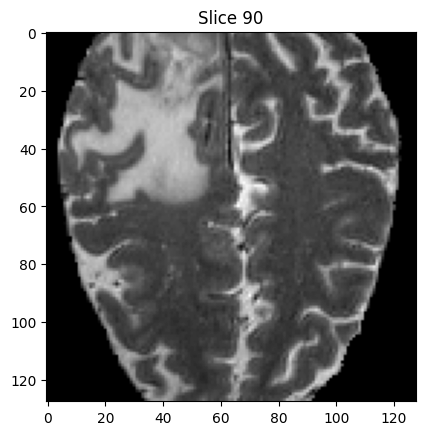

In [14]:
import torch.nn.functional as F

vol = nib.load('/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001/BraTS20_Validation_001_t2.nii').get_fdata()
slice_index = 90
rotated_vol = np.rot90(vol).copy()
transpose_vol = np.transpose(rotated_vol, (2, 0, 1))
cropped_vol = crop_center(transpose_vol,(128,128,128))
tensor_vol = torch.from_numpy(cropped_vol).float()
tensor_vol = F.interpolate(tensor_vol.unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False)
print(cropped_vol.shape)
plt.imshow(tensor_vol[0,0,slice_index,:,:], cmap='gray')
plt.title(f'Slice {slice_index}')
plt.show()

(16, 128, 128)


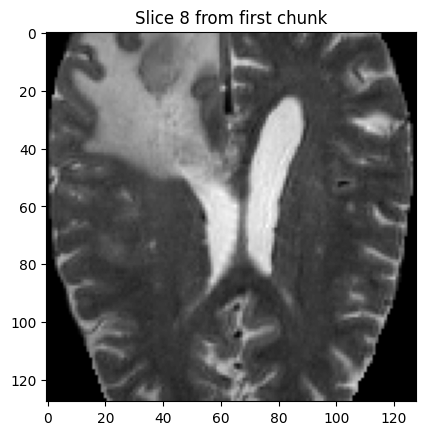

In [18]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the get_slices function
def get_slices(mri_volume):
    if mri_volume.shape != (128, 128, 128):
        raise ValueError("Input MRI volume must have shape (128, 128, 128).")

    slices = []
    for i in range(8):  # Dividing the volume into 8 chunks
        start = i * 16
        end = start + 16
        slice_chunk = mri_volume[start:end, :, :]  # Extracting a chunk along the first axis
        slices.append(slice_chunk)
    return slices

# Assume cropped_vol is already loaded and has shape (128, 128, 128)
slices_vol = get_slices(cropped_vol)
print(slices_vol[4].shape)

# # Convert one slice chunk to tensor and interpolate it
tensor_vol_slice = torch.from_numpy(slices_vol[4]).float()  # Convert the first chunk (shape: [16, 128, 128])
tensor_vol_slice = F.interpolate(tensor_vol_slice.unsqueeze(0).unsqueeze(0), size=(16, 128, 128), mode='trilinear', align_corners=False)

# # # Print the shape of one chunk (should be [16, 128, 128])


# # Visualize a specific slice
slice_index = 8  # Choose a slice index within the chunk
plt.imshow(tensor_vol_slice[0,0,slice_index, :, :], cmap='gray')  # Indexing a 3D array (no extra dimensions)
plt.title(f'Slice {slice_index} from first chunk')
plt.show()


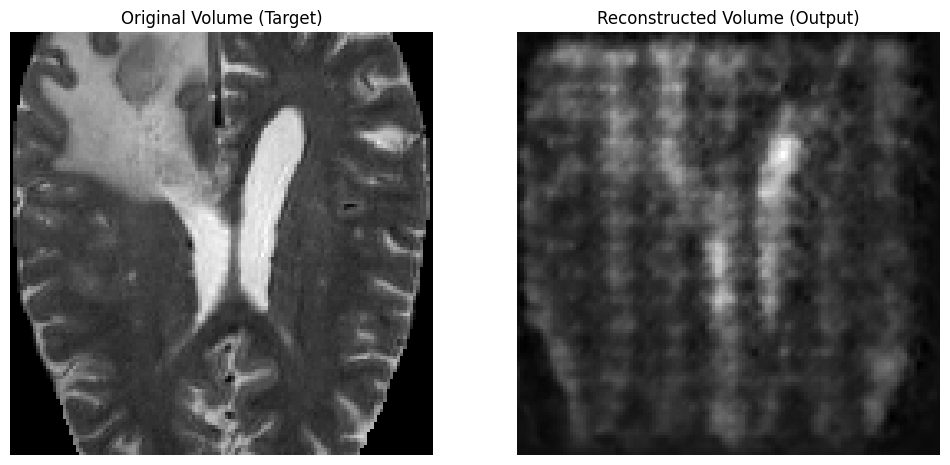

In [19]:
model_path = '/kaggle/input/3d-unet-slices/trained_model (5).pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

with torch.no_grad():
    tensor_vol_slice = tensor_vol_slice.to(device)
    output = model(tensor_vol_slice)
          
    depth = 8
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Original Volume (Target)
    ax[0].imshow(tensor_vol_slice[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
    ax[0].set_title('Original Volume (Target)')
    ax[0].axis('off')

    # Reconstructed Volume (Output)
    ax[1].imshow(output[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
    ax[1].set_title('Reconstructed Volume (Output)')
    ax[1].axis('off')

    plt.show()  # Display the plot



In [1]:
import os
import nibabel as nib

# Specify the path to the validation data folder and output folder
data_folder_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
output_folder_path = '/kaggle/working/preprocessed_t2'

# Create the output directory if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)

# Iterate through the directory, collect _t2.nii files, and save them to the new folder
for root, dirs, files in os.walk(data_folder_path):
    for file in files:
        if file.endswith('_t2.nii'):
            # Load the NIfTI file
            file_path = os.path.join(root, file)
            img = nib.load(file_path)
            
            # Save the file in the output folder with a modified name
            new_file_name = file.replace('_t2.nii', '_t2_preprocessed.nii')
            new_file_path = os.path.join(output_folder_path, new_file_name)
            nib.save(img, new_file_path)


In [4]:
anomaly_dataset = MRIDataset('/kaggle/working/preprocessed_t2')

In [6]:
print(anomaly_dataset[0][0][0].shape)

torch.Size([1, 16, 128, 128])


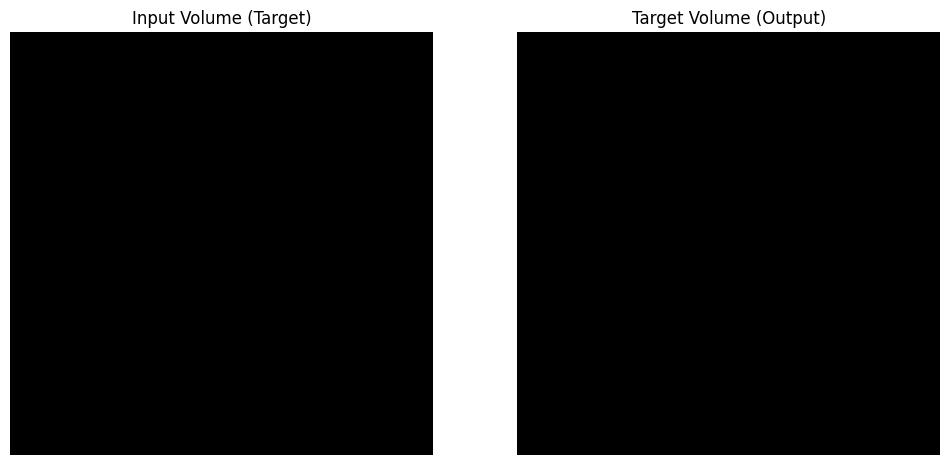

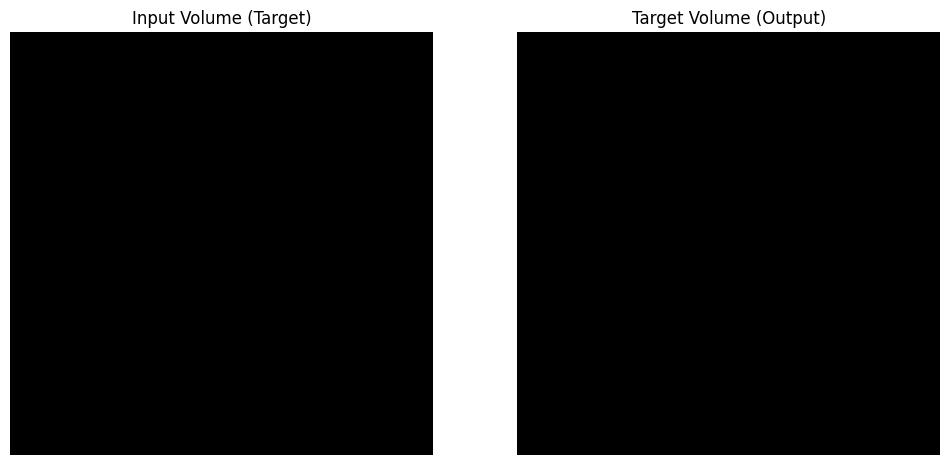

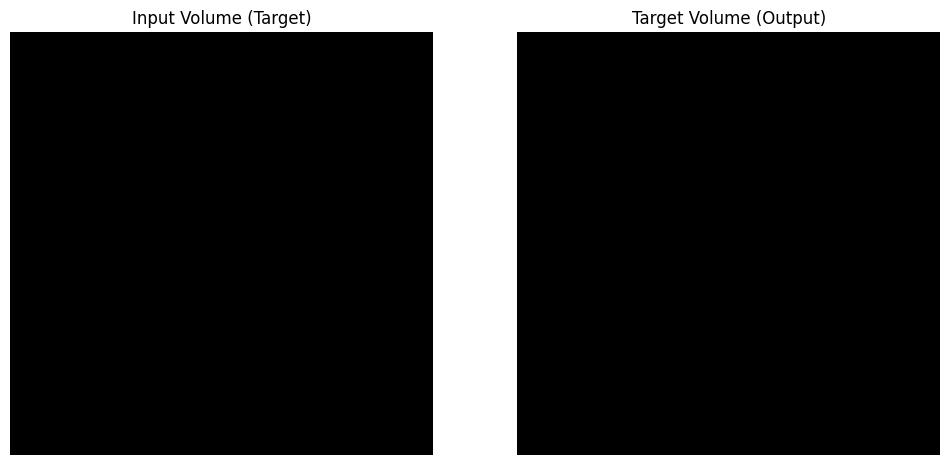

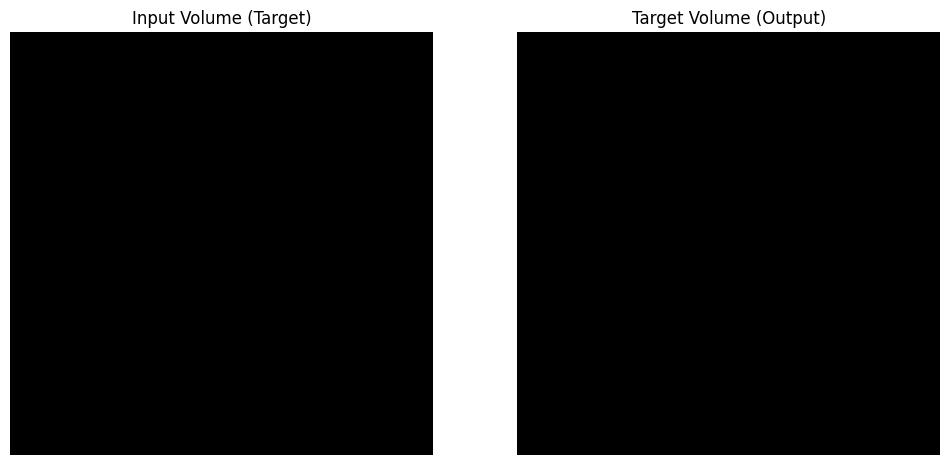

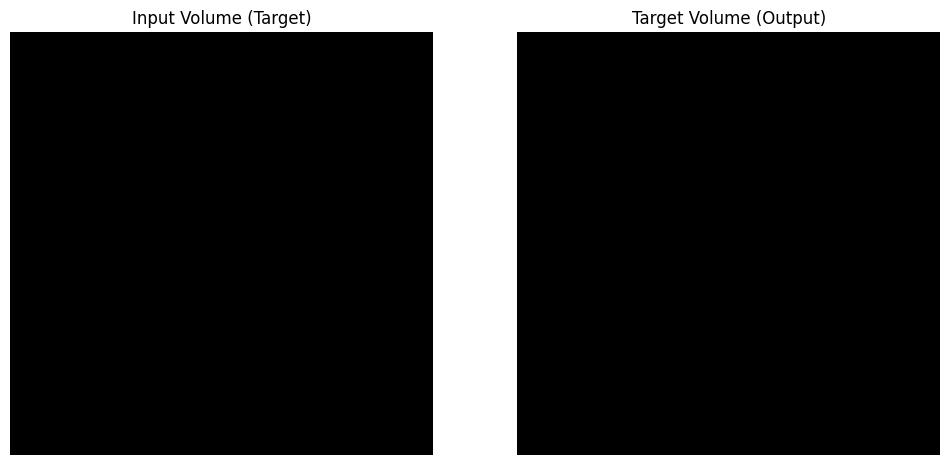

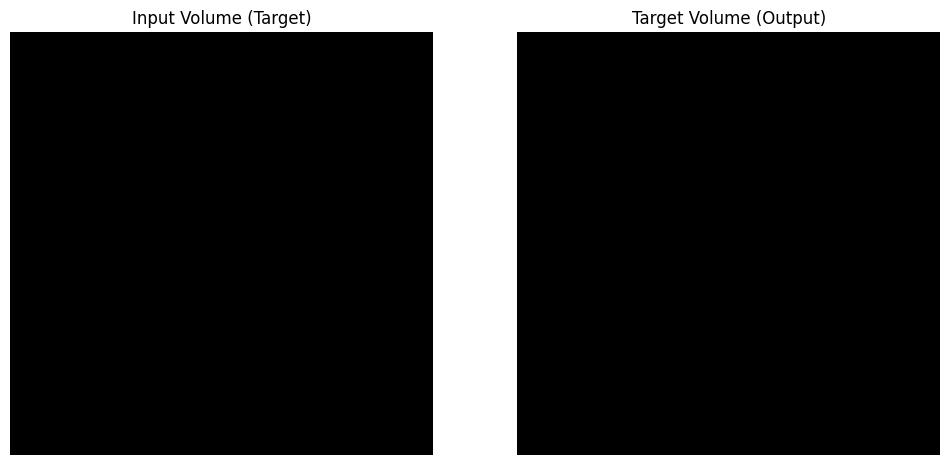

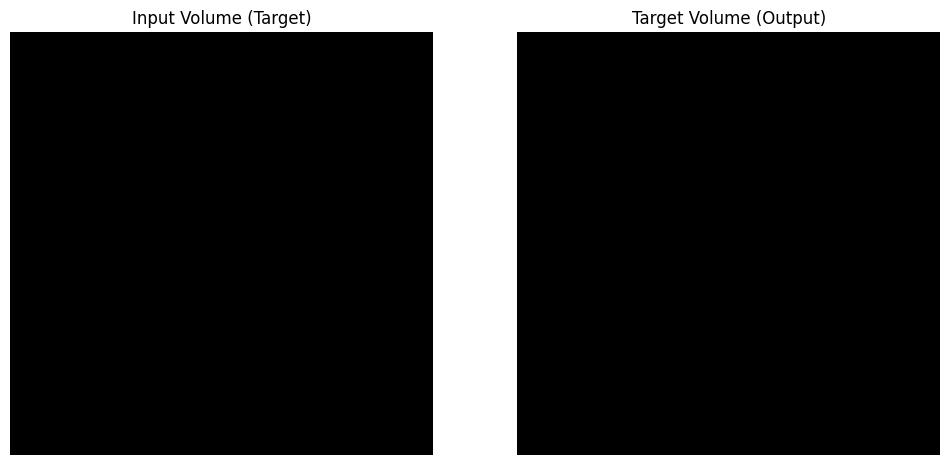

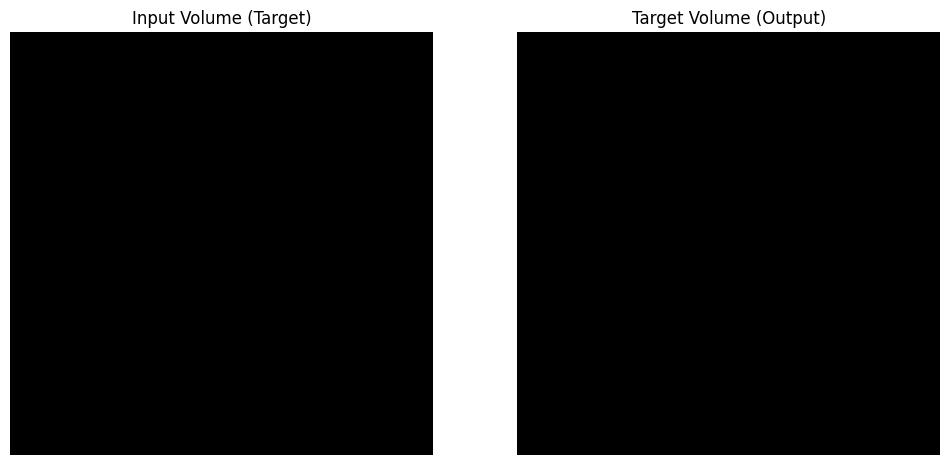

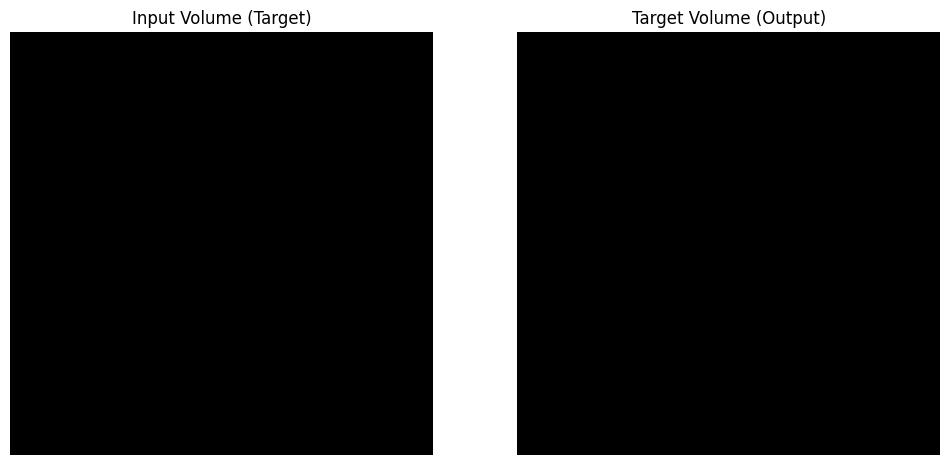

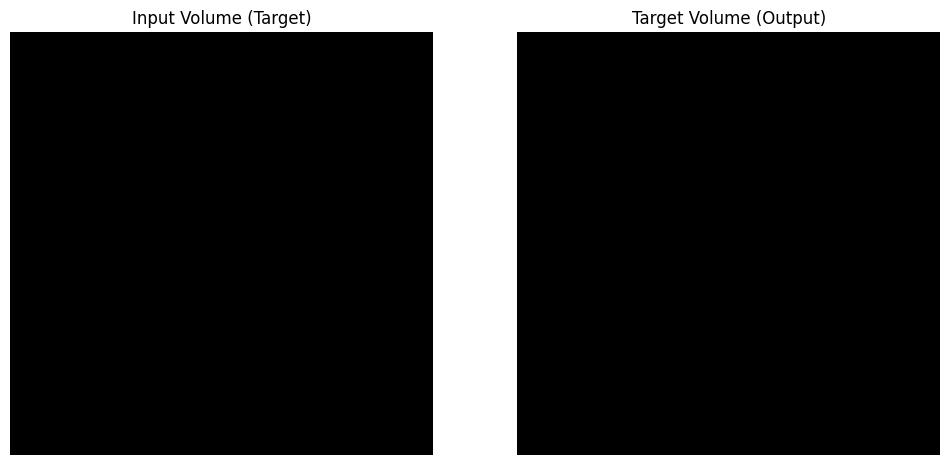

In [12]:
import matplotlib.pyplot as plt

for i in range(5):
    for j in range(2):
        original = anomaly_dataset[i][j][0]
        target = anomaly_dataset[i][j][1]
        
        depth = 8  
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original Volume (Target)
        ax[0].imshow(original[0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[0].set_title('Input Volume (Target)')
        ax[0].axis('off')

        # Reconstructed Volume (Output)
        ax[1].imshow(target[0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[1].set_title('Target Volume (Output)')
        ax[1].axis('off')
        
        plt.show()

Processing image-target pair 0 from volume 0...
mri_slice shape: torch.Size([1, 16, 128, 128]), target_slice shape: torch.Size([1, 16, 128, 128])


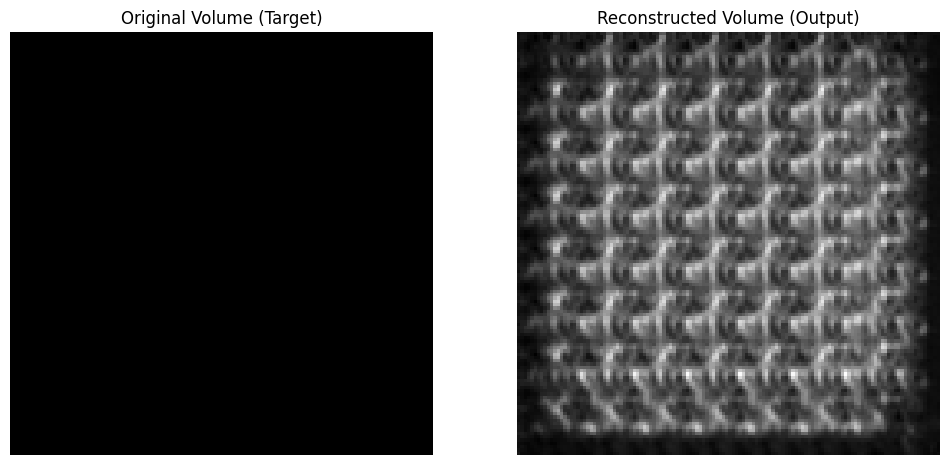

Processing image-target pair 1 from volume 0...
mri_slice shape: torch.Size([1, 16, 128, 128]), target_slice shape: torch.Size([1, 16, 128, 128])


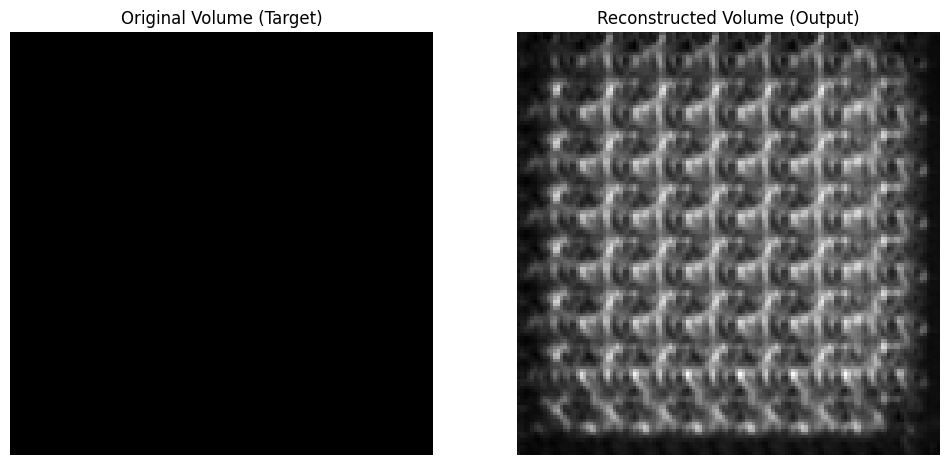

IndexError: tuple index out of range

In [36]:
import os
import matplotlib.pyplot as plt
import torch

# Load the model
model_path = '/kaggle/input/3d-unet-slices/trained_model (5).pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()
test_loss = 0.0

# Loop through the first 20 volumes in the anomaly dataset
for j in range(5): 
    anomaly_volume = anomaly_dataset[j]
    for i in range(8):
        # Create output directory if it doesn't exist
        output_dir = f'./output_{j}_slice_{i}'
        os.makedirs(output_dir, exist_ok=True)

        image_target_pairs = anomaly_volume[i]  # Get the ith pair of images
        print(f"Processing image-target pair {i} from volume {j}...")
        
        # Iterate through the image-target pair
        mri_slice = image_target_pairs[0]  # Assuming this contains the MRI slice
        target_slice = image_target_pairs[1]  # Assuming this contains the target slice

        # Check the shapes
        print(f"mri_slice shape: {mri_slice.shape}, target_slice shape: {target_slice.shape}")

        with torch.no_grad():  # Disable gradient calculations for testing
            # Prepare the input and target tensors, add batch and channel dimensions and move to GPU
            imgs = torch.tensor(mri_slice).unsqueeze(0).float().to(device)  # Shape: (1, 1, 16, 128, 128)
            targets = torch.tensor(target_slice).unsqueeze(0).float().to(device)  # Shape: (1, 1, 16, 128, 128)

            # Forward pass through the model
            outputs = model(imgs)
            loss = criterion(outputs, targets)  # Compute test loss
            test_loss += loss.item()

            # Visualize only the 4th slice (slice index 3 in depth)
            depth = 8  # You can choose any valid depth index (0 to 15 for your data)
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))

            # Original Volume (Target)
            ax[0].imshow(targets[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
            ax[0].set_title('Original Volume (Target)')
            ax[0].axis('off')

            # Reconstructed Volume (Output)
            ax[1].imshow(outputs[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
            ax[1].set_title('Reconstructed Volume (Output)')
            ax[1].axis('off')

            plt.show()  # Display the plot

            # Save outputs for each slice
            output_path = f'{output_dir}/output.pt'
            torch.save(outputs.cpu(), output_path)

# Print the total test loss
print(f'Total test loss: {test_loss}')
